# Building a Classifier for Article Categorization

## Introduction

In this notebook, we will focus on building and training a classifier that can accurately categorize Wikipedia articles based on their content. This task follows our previous work where we added category labels to our dataset using the Wikipedia API. Now, with categories assigned to each article, we can develop a model that will help improve the accuracy and efficiency of our article retrieval system.

## Objectives

- **Model Development**: Develop a machine learning model that can classify Wikipedia articles into predefined categories.
- **Training and Validation**: Train the classifier using the `qns_answers` dataset, which now includes category labels, and validate its performance.
- **Optimization**: Fine-tune the model to achieve the best possible classification accuracy.

## Approach

We will experiment with various classification algorithms to determine which provides the best performance in terms of accuracy and efficiency. We will also employ techniques like cross-validation and hyperparameter tuning to ensure the robustness of our model.

This notebook will document the entire process from model selection and training to evaluation, providing a thorough overview of the methods used and the outcomes achieved.

First things first, let's prepare our environment by importing the necessary libraries and then load the dataset to explore its structure and contents.

We will be importing the Sentence Transformer library, which is crucial for generating embeddings. These embeddings will help in efficiently comparing text similarity, which is essential for tasks like categorization where understanding the contextual relationship between texts improves the classifier's accuracy.

In [138]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [139]:
df_valid_articles = pd.read_csv('data/valid_articles.csv')

In [140]:
df_valid_articles.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,title,content,categories
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,Gibraltar,NaN,"['1700s in Spain', '1704 establishments in Eur..."
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,Currency,NaN,['All articles containing potentially dated st...
2,are a and b the same number?,78,Axiom,"([], [('are', 'ROOT', 'are'), ('a', 'attr', 'a...",106.67,b number,21690,https://simple.wikipedia.org/wiki/Axiom,An axiom is a concept in logic. It is a statem...,axiom concept logic statement assumed true wit...,Axiom,NaN,"['All articles with unsourced statements', 'Ar..."
3,are addition and multiplication dyadic functions?,48,Dyadic,"([], [('are', 'ROOT', 'are'), ('addition', 'nm...",14.63,addition multiplication dyadic function,3917,https://simple.wikipedia.org/wiki/Dyadic,A dyadic is a math function that needs two thi...,dyadic math function need two thing order give...,Dyadic,NaN,"['All article disambiguation pages', 'All disa..."
4,are albinic animals more likely to be attacked...,57,Albinism,"([('albinic', 'NORP')], [('are', 'ROOT', 'are'...",46.78,albinic animal likely attacked predator non al...,13767,https://simple.wikipedia.org/wiki/Albinism,"Albinism is a condition some people, animals, ...",albinism condition people animal plant born co...,Albinism,NaN,"['Albinism', 'All articles lacking reliable re..."


# Unsupervised Clustering Using Text and Categories

In this approach, we leverage both article text and their associated categories to perform unsupervised clustering. This method aims to group the articles into distinct categories based on the content and predefined categories, enhancing the thematic accuracy of the clusters.


**Category Encoding**: We start by encoding the categories using a `MultiLabelBinarizer`. This transforms the categorical labels into a binary format suitable for machine learning models.

In [141]:

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_valid_articles['categories'])

**Text Vectorization**: Next, we convert the preprocessed text into a numerical format using `TfidfVectorizer`. This technique assigns weights to the words based on their frequency and relevance in the corpus, allowing us to capture the importance of each term.

In [142]:
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df_valid_articles['preprocessed_text'])


**Feature Combination**: Finally, we combine the text features and the encoded category labels into a single matrix. This combined feature set will be used for clustering, ensuring that both textual content and categorical context influence the groupings.

In [143]:
X_combined = hstack([X, y])

By integrating text data with category information, this method seeks to refine our clustering outcomes, making it possible to more accurately discern and categorize the articles based on their overall content and thematic elements.

To identify the optimal number of clusters for our unsupervised clustering method, we utilize the Silhouette Score. This metric assesses the similarity of an object to its own cluster compared to other clusters, with scores ranging from -1 to +1. A higher score indicates that objects are well-matched to their own cluster and distinct from neighboring clusters, making it an effective tool for evaluating cluster configurations.

We apply the KMeans clustering algorithm, experimenting with cluster sizes ranging from 5 to 14. This variation allows us to observe how the Silhouette Score fluctuates, helping us identify the cluster size that optimizes intra-cluster similarity and inter-cluster distinctness.

Silhouette Score with n_clusters = 5: 0.11681980507079283
Silhouette Score with n_clusters = 6: 0.10580474577006274
Silhouette Score with n_clusters = 7: 0.10052722014929129
Silhouette Score with n_clusters = 8: 0.09931335253220448
Silhouette Score with n_clusters = 9: 0.09863797966858824
Silhouette Score with n_clusters = 10: 0.08938265017964198
Silhouette Score with n_clusters = 11: 0.09960661978728952
Silhouette Score with n_clusters = 12: 0.09796902875054694
Silhouette Score with n_clusters = 13: 0.09176666537251708
Silhouette Score with n_clusters = 14: 0.09342534457034628


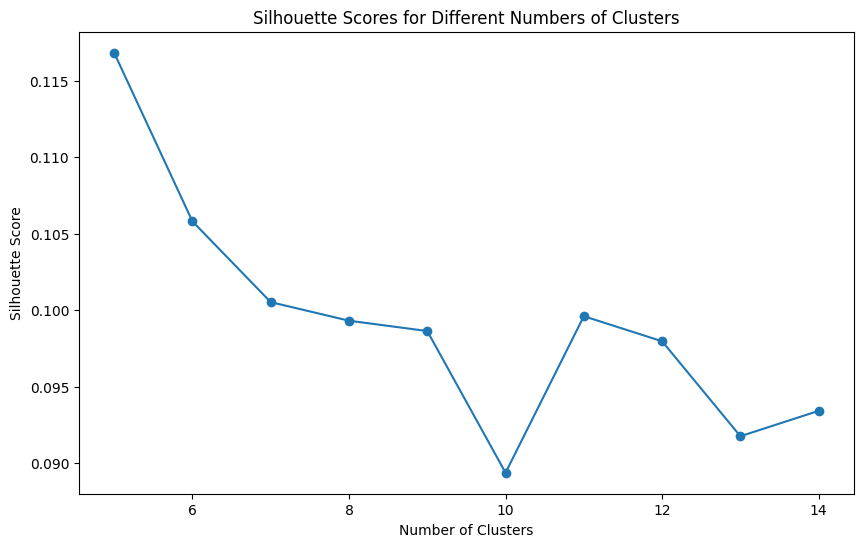

Optimal number of clusters based on silhouette score: 5


In [144]:
# Range of n_clusters values to evaluate
n_clusters_range = range(5, 15)

silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_combined)
    score = silhouette_score(X_combined, clusters)
    silhouette_scores.append(score)
    print(f"Silhouette Score with n_clusters = {n_clusters}: {score}")

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose the n_clusters with the highest silhouette score as optimal
optimal_n_clusters_silhouette = n_clusters_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters based on silhouette score: {optimal_n_clusters_silhouette}")

By using this method, we determine that the optimal number of clusters, based on the highest Silhouette Score, is 5. This configuration allows for the most efficient grouping of our dataset, maximizing intra-cluster similarity and minimizing inter-cluster overlap.

To refine our clustering process, we utilize the sentence transformer model 'all-MiniLM-L6-v2' from the MiniLM series. This model is specifically designed to be compact and efficient, providing robust language representations with less computational overhead than larger models like BERT or RoBERTa. It's particularly adept at generating sentence embeddings—compressing the semantic content of sentences into dense vectors. This capability is essential for tasks requiring deep text understanding, such as summarizing or matching articles, making it an ideal choice for our clustering needs.

In [145]:
# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(df_valid_articles['preprocessed_text'].tolist())

Furthermore, we employ Principal Component Analysis (PCA) to reduce the dimensionality of our embeddings. PCA helps in emphasizing variation and bringing out strong patterns in the dataset by filtering out noise and retaining only the most significant features, which are represented as principal components. These components are new variables created from linear combinations of the original variables, prioritized by the amount of variance they capture. This method is beneficial for enhancing cluster analysis by focusing on the most impactful data attributes.

In [146]:
pca = PCA(n_components=100) 
reduced_embeddings = pca.fit_transform(embeddings)

We analyze three different clustering approaches:

1. A KMeans clustering model that utilizes multilabel binarization on article text and categories.
2. A model employing only the embeddings generated from the article text.
3. A model that combines embeddings with PCA for dimensionality reduction.

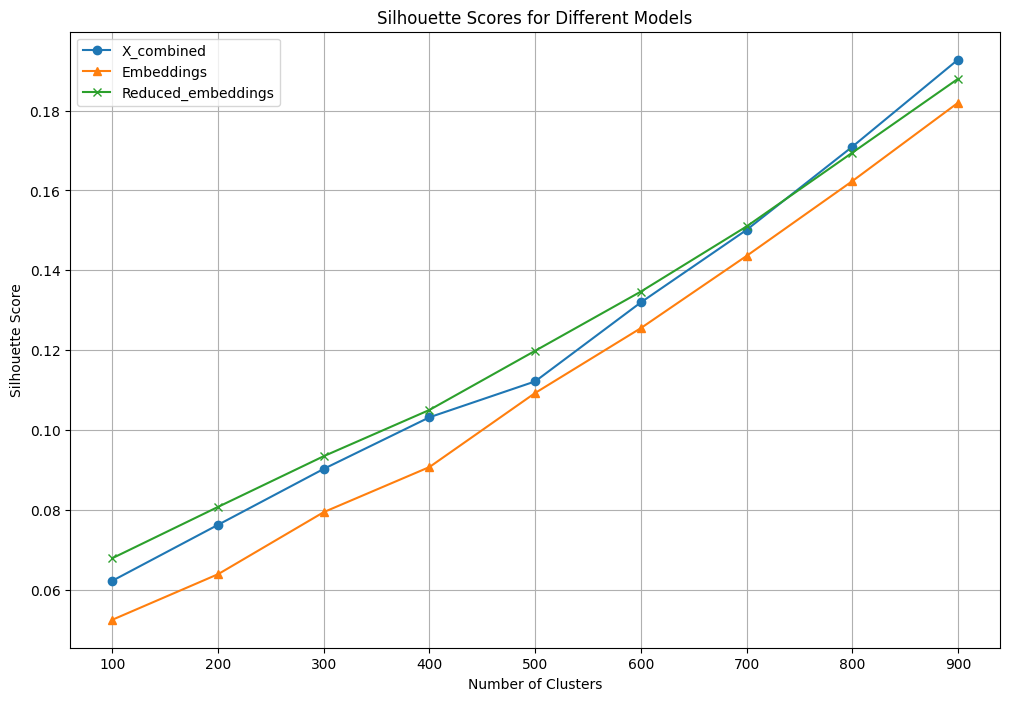

Optimal number of clusters for X_combined: 900
Optimal number of clusters for embeddings: 900
Optimal number of clusters for reduced_embeddings: 900


In [147]:
# Define a function to compute KMeans clustering and silhouette scores
def compute_silhouette_scores(X, n_clusters_range):
    silhouette_scores = []
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(X)
        score = silhouette_score(X, clusters)
        silhouette_scores.append(score)
    return silhouette_scores

# Define the range of n_clusters
n_clusters_range = np.arange(100, 1000, 100)

# Compute silhouette scores for each model
silhouette_scores_combined = compute_silhouette_scores(X_combined, n_clusters_range)
silhouette_scores_embeddings = compute_silhouette_scores(embeddings, n_clusters_range)
silhouette_scores_reduced = compute_silhouette_scores(reduced_embeddings, n_clusters_range)

# Plotting the Silhouette Scores
plt.figure(figsize=(12, 8))

plt.plot(n_clusters_range, silhouette_scores_combined, marker='o', label='X_combined')
plt.plot(n_clusters_range, silhouette_scores_embeddings, marker='^', label='Embeddings')
plt.plot(n_clusters_range, silhouette_scores_reduced, marker='x', label='Reduced_embeddings')

plt.title('Silhouette Scores for Different Models')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Determine the optimal number of clusters for each model
optimal_n_clusters_combined = n_clusters_range[np.argmax(silhouette_scores_combined)]
optimal_n_clusters_embeddings = n_clusters_range[np.argmax(silhouette_scores_embeddings)]
optimal_n_clusters_reduced = n_clusters_range[np.argmax(silhouette_scores_reduced)]

print(f"Optimal number of clusters for X_combined: {optimal_n_clusters_combined}")
print(f"Optimal number of clusters for embeddings: {optimal_n_clusters_embeddings}")
print(f"Optimal number of clusters for reduced_embeddings: {optimal_n_clusters_reduced}")


The results indicate that the reduced embeddings model not only performs better than the one using only embeddings but also marginally outperforms the initial multilabel model. This superiority is attributed to its enhanced ability to capture the essential semantic content of the data. Additionally, as the dataset's complexity and diversity expand, the optimal number of clusters tends to increase. This trend is typical in text data, where more clusters are often needed to accurately delineate distinct topics or patterns, as observed through silhouette scores in KMeans clustering models.

Despite the increasing need for more clusters, clustering with too many groups can lead to highly uneven distribution of articles across categories. To address this, we choose to form 250 clusters, striking a balance between performance optimization and ensuring a more equitable distribution of articles. If more time and resources were available, further exploration might lead to selecting different parameters for optimal clustering based on extended analysis and the evolving needs of the dataset.

In [148]:
# Clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=250, random_state=42)
df_valid_articles['cluster'] = kmeans_optimal.fit_predict(reduced_embeddings)

# Qualitative Analysis of the Clustered Articles
for i in range(optimal_n_clusters_embeddings):
    print(f"Cluster {i} titles:")
    print(df_valid_articles[df_valid_articles['cluster'] == i]['title'].head(10), "\n")  # Displaying the first 10 titles per cluster


Cluster 0 titles:
168     Hephaestus
757          Giant
1580        Hypnos
1599      Hercules
1622         Horae
1644         Nymph
1860        Aether
2054          Ares
2079          Maia
2226        Anubis
Name: title, dtype: object 

Cluster 1 titles:
3148    1709
3155    1667
5385    1780
5612    1654
5744    1802
5936    1698
8072    1871
8187    1543
8193    1870
8205    1816
Name: title, dtype: object 

Cluster 2 titles:
23       Random
40         Past
102       Event
526        Luck
528      Random
910        Coin
1542       Past
2108    Actuary
3231      Event
3768        Now
Name: title, dtype: object 

Cluster 3 titles:
373     Sheffield
860     Sheffield
1048      Cardiff
1104         Bath
1608       Surrey
1638     Plymouth
1639    Liverpool
2193     Brooklyn
2198       Surrey
2806         York
Name: title, dtype: object 

Cluster 4 titles:
280         Arctic
382            Oak
576         Desert
830         Forest
887          Sahel
1231    Antarctica
1275       Climate
1

In [149]:
df_valid_articles

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,title,content,categories,cluster
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,Gibraltar,NaN,"['1700s in Spain', '1704 establishments in Eur...",192
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,Currency,NaN,['All articles containing potentially dated st...,127
2,are a and b the same number?,78,Axiom,"([], [('are', 'ROOT', 'are'), ('a', 'attr', 'a...",106.67,b number,21690,https://simple.wikipedia.org/wiki/Axiom,An axiom is a concept in logic. It is a statem...,axiom concept logic statement assumed true wit...,Axiom,NaN,"['All articles with unsourced statements', 'Ar...",212
3,are addition and multiplication dyadic functions?,48,Dyadic,"([], [('are', 'ROOT', 'are'), ('addition', 'nm...",14.63,addition multiplication dyadic function,3917,https://simple.wikipedia.org/wiki/Dyadic,A dyadic is a math function that needs two thi...,dyadic math function need two thing order give...,Dyadic,NaN,"['All article disambiguation pages', 'All disa...",210
4,are albinic animals more likely to be attacked...,57,Albinism,"([('albinic', 'NORP')], [('are', 'ROOT', 'are'...",46.78,albinic animal likely attacked predator non al...,13767,https://simple.wikipedia.org/wiki/Albinism,"Albinism is a condition some people, animals, ...",albinism condition people animal plant born co...,Albinism,NaN,"['Albinism', 'All articles lacking reliable re...",209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10812,why were the apocrypha books removed from some...,50,Apocrypha,"([('1828', 'DATE')], [('why', 'advmod', 'were'...",94.15,apocrypha book removed bible,5361,https://simple.wikipedia.org/wiki/Apocrypha,The Apocrypha are religious texts that are in ...,apocrypha religious text version catholic bibl...,Apocrypha,NaN,"['All accuracy disputes', 'All articles with u...",142
10813,why were the pyramids built?,48,Pyramid,"([], [('why', 'advmod', 'built'), ('were', 'au...",100.24,pyramid built,8616,https://simple.wikipedia.org/wiki/Pyramid,"A pyramid is a structure, usually of stone, bu...",pyramid structure usually stone built shape py...,Pyramid,NaN,['All articles with broken links to citations'...,235
10814,will rabat be selected to host the 2020 summer...,72,Rabat,"([('2020 summer', 'DATE')], [('will', 'aux', '...",78.25,rabat selected host summer olympics,24281,https://simple.wikipedia.org/wiki/Rabat,"Rabat (, transliterated ar-Rabāṭ or ar-Ribāṭ, ...",rabat transliterated ar rabāṭ ar ribāṭ literal...,Rabat,NaN,"['3rd-century BC establishments', 'All article...",147
10815,will the michelin tire company still be in ope...,93,Prediction,"([('michelin', 'ORG'), ('the year 2050', 'DATE...",66.74,michelin tire company still operation year,630,https://simple.wikipedia.org/wiki/Prediction,A prediction is a statement that someone makes...,prediction statement someone make think going ...,Prediction,NaN,"['All articles with failed verification', 'All...",2


Upon reviewing the distribution of articles within our chosen 250 clusters, we observe that the number of articles per cluster is not entirely uniform. This variance in cluster size is anticipated due to the inherent diversity of article topics. For instance, some clusters are narrowly focused on very specific themes, such as articles detailing a particular historical event, which naturally tend to be smaller.

The clusters formed generally exhibit a central theme or topic, exemplifying the model's ability to group articles based on their content similarity effectively. Here are a few examples of the kinds of thematic clusters created:

1. Historical Events: Clusters that focus on specific historical occurrences, gathering all related articles that provide detailed insights into these events.
2. Technological Advances: Articles that discuss various technological innovations and their impacts grouped together, reflecting the thematic focus on science and technology.
3. Cultural Artifacts: Clusters that compile articles on cultural and artistic subjects, from music genres to classical art forms.


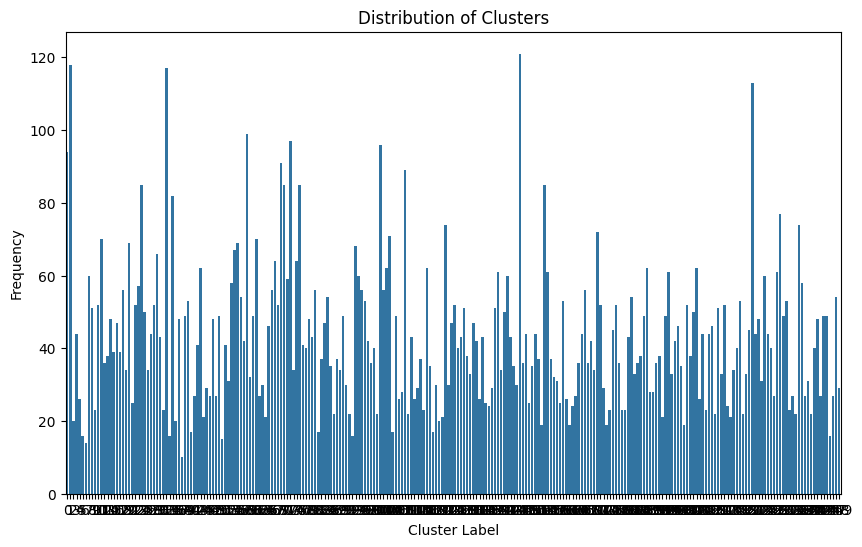

In [150]:
# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.countplot(x=df_valid_articles['cluster'])
plt.title('Distribution of Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.show()

The provided graph showcases the distribution of articles across the 250 clusters. It is evident that the distribution is non-uniform, with some clusters having a higher article frequency than others. This reflects the natural diversity in article topics and the varying scope of subject matter addressed by each cluster.

We are now focusing on categorizing the articles that have not yet been assigned to a cluster. To integrate these unclustered articles into our existing framework, we will utilize a K-Nearest Neighbors (KNN) approach.

The KNN algorithm will allow us to identify the nearest cluster centroids to our unclustered articles, based on their embeddings. Once identified, we can assign each unclustered article to the cluster of its nearest neighbor, thereby extending our categorization to the full dataset. This method ensures that every article is associated with a cluster that closely matches its content.

In [174]:
qns_answers = pd.read_csv('data/updated_qns_answers.csv')

In [175]:
qns_answers.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [('a', 'det', 'patient'), ('patient', 'ns...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...
4,"according to plato, what are the three types o...",55,The Republic,"([('three', 'CARDINAL')], [('according', 'prep...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...


In [176]:
qns_answers.shape[0]

21318

In [177]:
# Filter out already clustered articles
clustered_titles = set(df_valid_articles['title'])
unclustered_articles = qns_answers[~qns_answers['article'].isin(clustered_titles)]


In [178]:
# Generate embeddings for unclustered articles
unclustered_text_embeddings = model.encode(unclustered_articles['preprocessed_text'].tolist())

In [179]:
# Apply PCA to new embeddings
unclustered_reduced_embeddings = pca.transform(unclustered_text_embeddings)

To categorize the remaining unclustered articles, we employ a Nearest Neighbors algorithm. This technique involves matching each unclustered article to its closest counterpart in the space of our already clustered articles. We use the NearestNeighbors class with the ball_tree algorithm for efficient nearest neighbor searches within our high-dimensional embedding space.

By fitting the model to our original clustered embeddings and querying with the embeddings of unclustered articles, we can identify the nearest cluster for each article. Subsequently, we assign the unclustered articles to these identified clusters, effectively extending our clustering scheme to cover the entire dataset.

In [180]:
original_embeddings = reduced_embeddings
original_clusters = df_valid_articles['cluster'].values

# Assuming original_embeddings is where your original clustered embeddings are stored
nearest_neighbors = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nearest_neighbors.fit(original_embeddings)  # original_embeddings should be the embeddings of df_valid_articles

# Find the nearest neighbor in the original dataset for each new article
distances, indices = nearest_neighbors.kneighbors(unclustered_reduced_embeddings)

# Assign new articles to the same cluster as their nearest neighbor
new_article_clusters = original_clusters[indices.flatten()]



After identifying the nearest clusters for the unclustered articles, we update their 'cluster' assignments accordingly. Then, we merge these updated records back into the main `qns_answers` dataset. To maintain data integrity during this merge, we ensure that the 'article' field serves as a unique identifier, preventing any duplication of rows. This step finalizes the categorization process, allowing every article in our dataset to be associated with a cluster.

In [181]:
# Update the 'cluster' assignment in unclustered_articles
unclustered_articles.loc[:, 'cluster'] = new_article_clusters

# Incorporate the updated unclustered_articles back into qns_answers
qns_answers = pd.merge(qns_answers, unclustered_articles[['article', 'cluster']], on='article', how='left')



/var/folders/j3/2xy_ffxd6jq618phh49pk1b00000gn/T/ipykernel_3975/1688196008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unclustered_articles.loc[:, 'cluster'] = new_article_clusters


In [182]:
qns_answers

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,NaN
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,NaN
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0
3,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0
4,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0
...,...,...,...,...,...,...,...,...,...,...,...
36517,why were the jews killed during the holocaust?,49,The Holocaust,"([('jews', 'NORP')], [('why', 'advmod', 'kille...",88.74,jew killed holocaust,4469,https://simple.wikipedia.org/wiki/The%20Holocaust,"The Holocaust, sometimes called The Shoah (), ...",holocaust sometimes called shoah genocide nazi...,243.0
36518,why were the pyramids built?,48,Pyramid,"([], [('why', 'advmod', 'built'), ('were', 'au...",100.24,pyramid built,8616,https://simple.wikipedia.org/wiki/Pyramid,"A pyramid is a structure, usually of stone, bu...",pyramid structure usually stone built shape py...,NaN
36519,will rabat be selected to host the 2020 summer...,72,Rabat,"([('2020 summer', 'DATE')], [('will', 'aux', '...",78.25,rabat selected host summer olympics,24281,https://simple.wikipedia.org/wiki/Rabat,"Rabat (, transliterated ar-Rabāṭ or ar-Ribāṭ, ...",rabat transliterated ar rabāṭ ar ribāṭ literal...,NaN
36520,will the michelin tire company still be in ope...,93,Prediction,"([('michelin', 'ORG'), ('the year 2050', 'DATE...",66.74,michelin tire company still operation year,630,https://simple.wikipedia.org/wiki/Prediction,A prediction is a statement that someone makes...,prediction statement someone make think going ...,NaN


In [183]:
qns_answers.shape[0]

36522

We have established a direct mapping from each article title to its designated cluster label. By applying this mapping to our main `qns_answers` dataset, we've created a new column that aligns every article with its respective cluster. 

To ensure completeness, we've replaced any missing cluster labels in the 'cluster' column with the corresponding labels from our new mapping. After this update, the 'mapped_cluster' column, now redundant, has been removed. The `qns_answers` dataset is now fully updated, with each article accurately labeled with its cluster assignment, ready for further analysis or modeling.

In [184]:
# Create a mapping from article titles to cluster labels
cluster_mapping = df_valid_articles.set_index('article')['cluster'].to_dict()

# Use the map function to create a new column that maps the article title to its cluster
qns_answers['mapped_cluster'] = qns_answers['article'].map(cluster_mapping)

# Fill NaN values in the 'cluster' column with the values from 'mapped_cluster'
qns_answers['cluster'].fillna(qns_answers['mapped_cluster'], inplace=True)
qns_answers.drop(columns=['mapped_cluster'], inplace=True)
print(qns_answers)

                                                question  points  \
0       did the people of gibraltar vote to remain pa...      58   
1       which country uses the franc as its official ...      55   
2       which of these old communist parties no longe...      52   
3       which of these old communist parties no longe...      52   
4       which of these old communist parties no longe...      52   
...                                                  ...     ...   
36517     why were the jews killed during the holocaust?      49   
36518                       why were the pyramids built?      48   
36519  will rabat be selected to host the 2020 summer...      72   
36520  will the michelin tire company still be in ope...      93   
36521  вhat iz da l33t sp34k f0r 'how are you?' in leet?      73   

                         article  \
0                      Gibraltar   
1                       Currency   
2      List of communist parties   
3      List of communist parties   
4  

/var/folders/j3/2xy_ffxd6jq618phh49pk1b00000gn/T/ipykernel_3975/2779828005.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  qns_answers['cluster'].fillna(qns_answers['mapped_cluster'], inplace=True)


In [185]:
grouped_qns_answers = qns_answers.groupby('article').agg({
    'question': lambda x: ' | '.join(x),  # Concatenate questions separated by '|'
    'points': 'sum',  # Sum points for the same article
    'cluster': lambda x: ', '.join(x.astype(str))  # Concatenate cluster assignments
}).reset_index()

print(grouped_qns_answers)


                      article  \
0         "Weird Al" Yankovic   
1            's-Hertogenbosch   
2                          0s   
3                           1   
4                  1 (number)   
...                       ...   
9601                   Zürich   
9602   Ólafur Ragnar Grímsson   
9603                     Łódź   
9604  Şükrü Saracoğlu Stadium   
9605                  ΜCLinux   

                                               question  points  \
0     what is the name of alfred's father, as mentio...     675   
1     what is the population of 's-hertogenbosch acc...     238   
2     who was the legendary high king of ireland dur...     134   
3     what is the name of the poem written by ovid i...     216   
4     what is the grade for 'very good' in germany a...     633   
...                                                 ...     ...   
9601  what is the headquarters of fifa located in? |...     591   
9602  what is the current president of iceland's nam...     214   


In the final polishing steps, we focus on identifying duplicate pairs of questions and articles within our dataset. We treat the first occurrence of each pair as unique and mark subsequent occurrences as duplicates.

The process involves filtering our `qns_answers` DataFrame to isolate these duplicates, which are then sorted by both 'question' and 'article' to cluster similar entries together. This sorting facilitates an easier review process, allowing us to inspect and address any redundancies in our dataset. The sorted duplicates are then displayed, providing a clear view of the question-answer pairs that require further attention.

In [186]:
# Identify duplicated question-cluster pairs (considering only the first occurrence as non-duplicate)
duplicated_rows = qns_answers.duplicated(subset=['question', 'article'], keep=False)

# Filter the DataFrame to only include the duplicated rows
duplicated_qns_answers = qns_answers[duplicated_rows]

# Sort the DataFrame by 'question' and 'cluster' to group duplicates together for easier review
duplicated_qns_answers_sorted = duplicated_qns_answers.sort_values(by=['question', 'article'])
print(duplicated_qns_answers_sorted)

                                                question  points  \
2       which of these old communist parties no longe...      52   
3       which of these old communist parties no longe...      52   
4       which of these old communist parties no longe...      52   
5      a patient has a terminal illness and wants to ...      65   
6      a patient has a terminal illness and wants to ...      65   
...                                                  ...     ...   
36512  why was sacramento an important port town in t...      56   
36513  why was sacramento an important port town in t...      56   
36515     why were the jews killed during the holocaust?      49   
36516     why were the jews killed during the holocaust?      49   
36517     why were the jews killed during the holocaust?      49   

                         article  \
2      List of communist parties   
3      List of communist parties   
4      List of communist parties   
5                 Medical ethics   
6  

In [187]:
# Remove duplicated rows based on 'question' and 'cluster', keeping the first instance
qns_answers = qns_answers.drop_duplicates(subset=['question', 'article'], keep='first')

# Reset the index
qns_answers.reset_index(drop=True, inplace=True)
print(qns_answers)

                                                question  points  \
0       did the people of gibraltar vote to remain pa...      58   
1       which country uses the franc as its official ...      55   
2       which of these old communist parties no longe...      52   
3      a patient has a terminal illness and wants to ...      65   
4      according to plato, what are the three types o...      55   
...                                                  ...     ...   
21313     why were the jews killed during the holocaust?      49   
21314                       why were the pyramids built?      48   
21315  will rabat be selected to host the 2020 summer...      72   
21316  will the michelin tire company still be in ope...      93   
21317  вhat iz da l33t sp34k f0r 'how are you?' in leet?      73   

                         article  \
0                      Gibraltar   
1                       Currency   
2      List of communist parties   
3                 Medical ethics   
4  

In [188]:
# Find any NA values in cluster column
qns_answers[qns_answers['cluster'].isna()]

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster


It looks like we are good to save our current progress and move on to the next steps.

In [189]:
qns_answers.to_csv('./data/updated_qns_answers.csv', index=False)